In [2]:
# 分類作業の下準備
import glob, json, base64, oci_client, params
from oci.ai_vision import AIServiceVisionClient

# 3_create_model で保存しておいたモデル情報を取り出す
with open(f'model_{params.model_name}.json') as f:
    model_info = json.load(f)

# 分類対象となるレモンの画像のリスト
files = glob.glob("data/**/*.jpg")
def convert_file_to_b64_string(file_path):
    with open(file_path, "rb") as f:
        return base64.b64encode(f.read()).decode('UTF-8')

vision_client = oci_client.get(AIServiceVisionClient) # type: AIServiceVisionClient

### Let's Classify Lemons !

good_quality_1097.jpg (elapsed time: 165.991 msec)


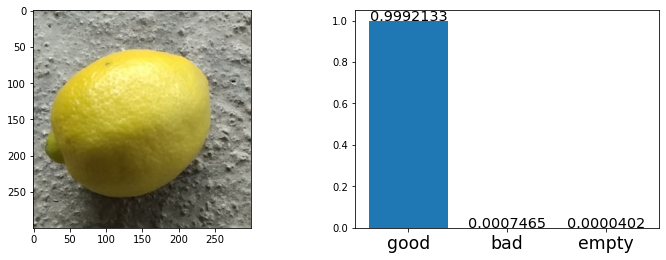

In [22]:

import time, json, random, re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import params, oci_client
from oci.ai_vision.models import AnalyzeImageDetails, AnalyzeImageResult, ImageClassificationFeature, InlineImageDetails, Label

model_id = model_info.get('id')

# 分類する画像ファイルをランダムに選ぶ
num = random.randint(0,len(files))
image_file = files[num]
file_name = re.compile(r'^.*/([^/]+)$').match(image_file).group(1)

perf_start = time.perf_counter() # 計測スタート

# AI Vision の呼び出し
feature = ImageClassificationFeature(feature_type='IMAGE_CLASSIFICATION', max_results=3, model_id=model_id)
image = InlineImageDetails(source='INLINE', data=convert_file_to_b64_string(image_file))
analyze_image_details = AnalyzeImageDetails(
    features=[feature],
    image=image,
    compartment_id=params.compartment_id
)
response = vision_client.analyze_image(analyze_image_details)
analyze_result = response.data # type: AnalyzeImageResult

perf_end = time.perf_counter() # 計測エンド

# 結果の表示
print(f'{file_name} (elapsed time: {(perf_end - perf_start)*1000:.3f} msec)')

%matplotlib inline
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(mpimg.imread(image_file),cmap="gray")

confidences = {}
for label in analyze_result.labels:
    confidences[label.name] = [label.confidence]
df = pd.DataFrame(confidences)
#print(df)

ax2.bar(df.columns, df.loc[0])
for i in range(0, len(df.columns)):
    plt.annotate(f"{df.loc[0][i]:.7f}", (i,df.loc[0][i]), ha="center", fontsize='x-large')
plt.xticks(fontsize='xx-large')
plt.show()